<a href="https://colab.research.google.com/github/cleverice007/ML2021-Spring/blob/main/deeplearning_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 51.9MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 27.5MB/s]


In [2]:
import pandas as pd

# 讀取 CSV
df = pd.read_csv('covid.train.csv')  # 或 'covid.test.csv'

# 印出欄位名稱
print(df.columns.tolist())

['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious', 'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1', 'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wearing_mask.2', 'travel_outside_state.2', 'work_outside_home.2', 'shop.2', 'restaurant.2', 'spent_t

In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()


In [5]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + [57, 75]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)


In [6]:

def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [21]:

import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    ''' A fully-connected deep neural network with improved performance '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Add more layers, BatchNorm and Dropout to improve performance
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),          # increased hidden size
            nn.BatchNorm1d(64),                # add BatchNorm for stable training
            nn.ReLU(),
            nn.Dropout(0.2),                    # add Dropout to reduce overfitting

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),                 # add another BatchNorm layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)                    # final regression output
        )

        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        # squeeze output to (batch_size,)
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, l1_lambda=0.0, l2_lambda=0.0):
        loss = self.criterion(pred, target)

        # Add L1 regularization term
        if l1_lambda > 0:
            l1 = sum(torch.sum(torch.abs(p)) for p in self.parameters())
            loss += l1_lambda * l1

        # Add L2 regularization term
        if l2_lambda > 0:
            l2 = sum(torch.sum(p ** 2) for p in self.parameters())
            loss += l2_lambda * l2

        return loss


In [20]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}  # for recording training loss
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()  # set model to training mode

        for x, y in tr_set:  # iterate through the dataloader
            optimizer.zero_grad()  # set gradient to zero
            x, y = x.to(device), y.to(device)  # move data to device
            pred = model(x)  # forward pass

            # compute loss with L1/L2 regularization support
            mse_loss = model.cal_loss(
                pred, y,
                l1_lambda=config.get('l1_lambda', 0.0),
                l2_lambda=config.get('l2_lambda', 0.0)
            )

            mse_loss.backward()  # backpropagation
            optimizer.step()  # update weights
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # Validation after each epoch
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, val_loss = {:.4f})'
                  .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)

        # Early stopping check
        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


In [27]:

def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [9]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [22]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

seed = 459
np.random.seed(seed)
delta = np.random.normal(loc=0,scale = 0.000001)

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 128,               # mini-batch size for dataloader
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of Adam
    },
    'l1_lambda':1e-6,        # L1 regularization
    'l2_lambda': 1e-4,
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}


myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [11]:

tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 42)


In [28]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device


In [29]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)


Saving model (epoch =    1, val_loss = 327.5214)
Saving model (epoch =    2, val_loss = 321.4459)
Saving model (epoch =    3, val_loss = 311.7056)
Saving model (epoch =    4, val_loss = 299.1652)
Saving model (epoch =    5, val_loss = 288.0822)
Saving model (epoch =    6, val_loss = 280.2327)
Saving model (epoch =    7, val_loss = 274.2568)
Saving model (epoch =    8, val_loss = 268.5315)
Saving model (epoch =    9, val_loss = 263.4160)
Saving model (epoch =   10, val_loss = 258.3325)
Saving model (epoch =   11, val_loss = 252.7298)
Saving model (epoch =   12, val_loss = 248.2122)
Saving model (epoch =   13, val_loss = 242.7381)
Saving model (epoch =   14, val_loss = 236.7850)
Saving model (epoch =   15, val_loss = 229.2674)
Saving model (epoch =   16, val_loss = 221.8061)
Saving model (epoch =   17, val_loss = 215.0916)
Saving model (epoch =   18, val_loss = 206.2692)
Saving model (epoch =   19, val_loss = 198.7592)
Saving model (epoch =   20, val_loss = 191.0208)
Saving model (epoch 

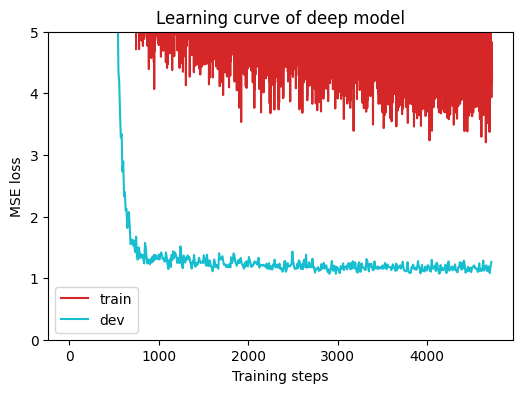

In [30]:
plot_learning_curve(model_loss_record, title='deep model')


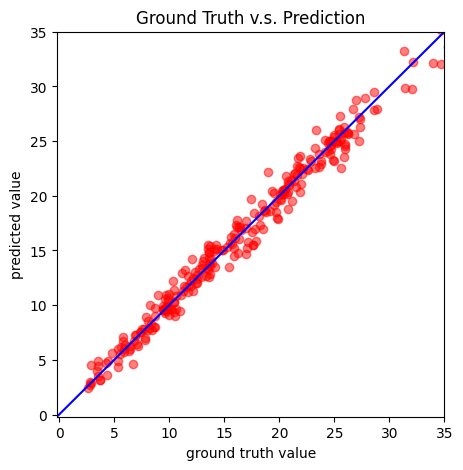

In [26]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set


In [19]:


def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
